In [1]:
import numpy as np 
import pandas as pd 
import keras
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn import metrics
import os
from PIL import Image

RESAMPLE_PER_CLASS_DICT = {0:0, 1:12, 2:5, 3:26, 4:28}

def re_sample(IMAGE_ARR, LABEL, TRAIN_IMAGE_ARRAY, TRAIN_LABEL_ARRAY):
    RANGE = RESAMPLE_PER_CLASS_DICT[LABEL]
    for i in range(RANGE):
        TRAIN_IMAGE_ARRAY.append(IMAGE_ARR)
        TRAIN_LABEL_ARRAY.append(LABEL)
    return TRAIN_IMAGE_ARRAY,TRAIN_LABEL_ARRAY      

Using TensorFlow backend.


**Read input images and training label and re-sample using above re-sample method. "RESAMPLE_PER_CLASS_DICT" defines the re-sampling rate for different classes.**

In [2]:
images = []
inputLabels = []
count = 0
trainLabels = pd.read_csv('/input/diabetic-retinopathy-detection/trainLabels.csv')
label_dict = {}

current_input_train_labels = []
current_input_test_labels = []

current_total_labels = []

input_image_matrix = []
test_image_matrix = []

for i in range(len(trainLabels)):
    label_dict[trainLabels.iloc[i].image] = trainLabels.iloc[i].level
    
for dirname, _, filenames in os.walk('/input'):
    for filename in filenames:
        if(filename == 'trainLabels.csv'):
            continue
        imagePath = os.path.join(dirname, filename)
        image = Image.open(imagePath)
        im = image.resize((512, 512))
        arr = keras.preprocessing.image.img_to_array(im)
        current_total_labels.append(label_dict[filename.split('.')[0]])
        if(count <= 800):
            current_input_train_labels.append(label_dict[filename.split('.')[0]])
            input_image_matrix.append(arr)
            inputLabels.append(label_dict[filename.split('.')[0]])      
            input_image_matrix, inputLabels = re_sample(arr, int(label_dict[filename.split('.')[0]]), input_image_matrix, inputLabels)
        else:
            current_input_test_labels.append(label_dict[filename.split('.')[0]])
            test_image_matrix.append(arr)
        count = count + 1

# Any results you write to the current directory are saved as output.

(array([25810.,     0.,  2443.,     0.,     0.,  5292.,     0.,   873.,
            0.,   708.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <a list of 10 Patch objects>)

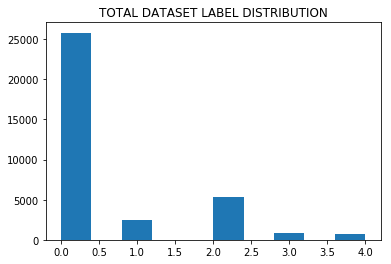

In [3]:
plt.title("TOTAL DATASET LABEL DISTRIBUTION")
plt.hist(trainLabels.level)

(array([739.,   0.,  59.,   0.,   0., 148.,   0.,  28.,   0.,  26.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <a list of 10 Patch objects>)

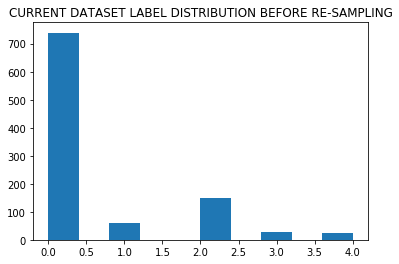

In [4]:
plt.title("CURRENT DATASET LABEL DISTRIBUTION BEFORE RE-SAMPLING")
plt.hist(current_total_labels)

(array([589.,   0., 611.,   0.,   0., 720.,   0., 594.,   0., 667.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <a list of 10 Patch objects>)

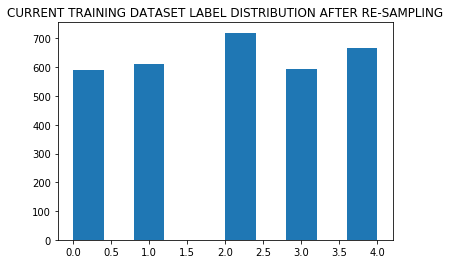

In [5]:
plt.title("CURRENT TRAINING DATASET LABEL DISTRIBUTION AFTER RE-SAMPLING")
plt.hist(inputLabels)

(array([150.,   0.,  12.,   0.,   0.,  28.,   0.,   6.,   0.,   3.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <a list of 10 Patch objects>)

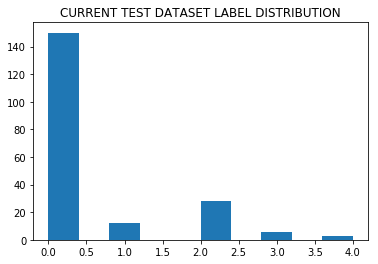

In [6]:
plt.title("CURRENT TEST DATASET LABEL DISTRIBUTION")
plt.hist(current_input_test_labels)

In [8]:
train_image_matrix = np.asarray(input_image_matrix[:2000])

In [10]:
one_hot_vector_labels = keras.utils.to_categorical(inputLabels, 5)

**Baseline Logistic Regression model**

In [11]:
#BASELINE MODEL: LOGISTIC REGRESSION
LR_BASELINE = keras.models.Sequential([
    keras.layers.Flatten(),
    keras.layers.Dense(1, activation='sigmoid'),
    keras.layers.Dense(5, activation='softmax')
])

LR_BASELINE.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])

LR_BL_MODEL = LR_BASELINE.fit(train_image_matrix, one_hot_vector_labels[:2000], epochs=20)

LR_BASELINE.summary()

Epoch 1/20
2000/2000 [==============================] - 8s 4ms/step - loss: 1.6123 - accuracy: 0.1870
Epoch 2/20
2000/2000 [==============================] - 8s 4ms/step - loss: 1.6076 - accuracy: 0.2185
Epoch 3/20
2000/2000 [==============================] - 8s 4ms/step - loss: 1.6067 - accuracy: 0.2100
Epoch 4/20
2000/2000 [==============================] - 8s 4ms/step - loss: 1.6060 - accuracy: 0.2070
Epoch 5/20
2000/2000 [==============================] - 8s 4ms/step - loss: 1.6056 - accuracy: 0.2175
Epoch 6/20
2000/2000 [==============================] - 8s 4ms/step - loss: 1.6052 - accuracy: 0.2175
Epoch 7/20
2000/2000 [==============================] - 8s 4ms/step - loss: 1.6050 - accuracy: 0.2175
Epoch 8/20
2000/2000 [==============================] - 8s 4ms/step - loss: 1.6049 - accuracy: 0.2175
Epoch 9/20
2000/2000 [==============================] - 8s 4ms/step - loss: 1.6047 - accuracy: 0.2175
Epoch 10/20
2000/2000 [==============================] - 8s 4ms/step - loss: 1.604

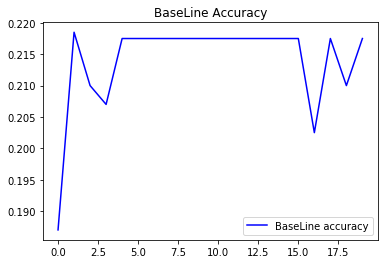

In [12]:
accuracy = LR_BL_MODEL.history['accuracy']
loss = LR_BL_MODEL.history['loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'b', label='BaseLine accuracy')
plt.title('BaseLine Accuracy')
plt.legend()
plt.show()

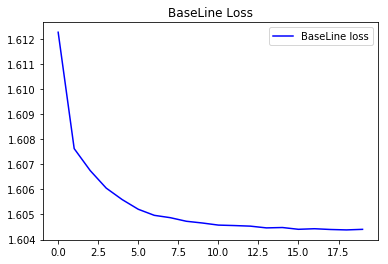

In [14]:
plt.plot(epochs, loss, 'b', label='BaseLine loss')
plt.title('BaseLine Loss')
plt.legend()
plt.show()

**Proposed Convolutional Neural Netwok model:**

In [23]:
model = keras.models.Sequential([
  keras.layers.Conv2D(32, (4, 4), strides=2, activation='relu', input_shape=(512, 512, 3), data_format="channels_last"),
  keras.layers.Conv2D(32, (4, 4), strides=1, activation='relu', input_shape=(255, 255, 32), data_format="channels_last"),  
  keras.layers.MaxPooling2D(pool_size=(3, 3), strides=2, data_format="channels_last"),  
  keras.layers.Conv2D(64, (4, 4), strides=2, activation='relu', input_shape=(127, 127, 32), data_format="channels_last"),
  keras.layers.Conv2D(64, (4, 4), strides=1, activation='relu', input_shape=(62, 62, 64), data_format="channels_last"),  
  keras.layers.MaxPooling2D(pool_size=(3, 3), strides=2, data_format="channels_last"),  
  keras.layers.Conv2D(128, (4, 4), activation='relu', input_shape=(31, 31, 64), data_format="channels_last"),
  keras.layers.Conv2D(128, (4, 4), padding="same", activation='relu', input_shape=(28, 28, 128), data_format="channels_last"),
  keras.layers.Conv2D(128, (4, 4), activation='relu', input_shape=(28, 28, 128), data_format="channels_last"),  
  keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2, data_format="channels_last"),
  keras.layers.Conv2D(64, (2, 2), strides=2, activation='relu', input_shape=(14, 14, 128), data_format="channels_last"),  
  keras.layers.MaxPooling2D(pool_size=(2, 2), data_format="channels_last"),  
  keras.layers.Flatten(),
  keras.layers.Dense(1024, activation='relu', kernel_initializer=keras.initializers.glorot_normal()), 
  keras.layers.BatchNormalization(epsilon=1e-5, gamma_initializer="uniform"),    
  keras.layers.Dense(512, activation='relu', kernel_initializer=keras.initializers.glorot_normal()),
  keras.layers.Dense(512, activation='relu', kernel_initializer=keras.initializers.glorot_normal()),  
  keras.layers.Dense(128, activation='relu', kernel_initializer=keras.initializers.glorot_normal()),  
  keras.layers.Dense(64, activation='relu', kernel_initializer=keras.initializers.glorot_normal()),  
  keras.layers.Dense(5, activation='softmax', kernel_initializer=keras.initializers.glorot_normal())  
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

MOD = model.fit(train_image_matrix, one_hot_vector_labels[:2000], epochs=50)


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 255, 255, 32)      1568      
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 252, 252, 32)      16416     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 125, 125, 32)      0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 61, 61, 64)        32832     
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 58, 58, 64)        65600     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 28, 28, 64)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 25, 25, 128)      

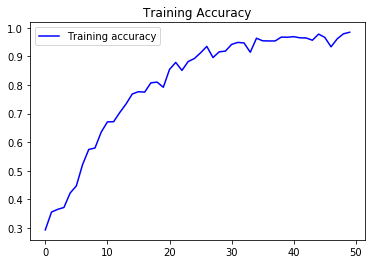

In [24]:
accuracy = MOD.history['accuracy']
loss = MOD.history['loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'b', label='Training accuracy')
plt.title('Training Accuracy')
plt.legend()
plt.show()

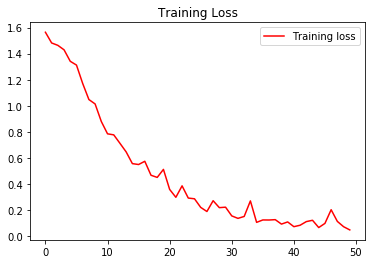

In [25]:
plt.plot(epochs, loss, 'r', label='Training loss')
plt.title('Training Loss')
plt.legend()
plt.show()

In [26]:
test_images_ = np.asarray(test_image_matrix)
PREDICT = model.predict_classes(test_images_)
metrics.accuracy_score(PREDICT, current_input_test_labels)

0.6231155778894473